In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import numpy as np

In [2]:
def create_graph(num_nodes, num_edges, node_value_range = [0, 100], edge_weight_range = [0,1], nb_of_sources = 0, nb_of_sinks = 0, tips_are_sources_or_sinks = True):
    """
    Creates a single component random graph with the specified number of nodes and edges.
    The value of each node is randomly selected from the range specified by node_value_range.
    The weight of each edge is randomly selected from the range specified by edge_weight_range.
    """
    G = nx.Graph()

    # Create nodes with random values
    for node in range(1, num_nodes + 1):
        G.add_node(node, value=random.uniform(node_value_range[0], node_value_range[1]))

    if nb_of_sources > 0:
        #Randomly select 'nb_of_sources' nodes to be sources (i.e. have value to node_value_range[1])
        sources = random.sample(range(1, num_nodes + 1), nb_of_sources)
        for source in sources:
            print("Added source: ", source)
            G.nodes[source]['value'] = node_value_range[1]
        
    if nb_of_sinks > 0:
        #Randomly select 'nb_of_sinks' nodes to be sinks (i.e. have value to node_value_range[0]), out of the nodes that are not sources
        sinks = random.sample([node for node in range(1, num_nodes + 1) if node not in sources], nb_of_sinks)
        for sink in sinks:
            print("Added sink: ", sink)
            G.nodes[sink]['value'] = node_value_range[0]
                    

    # Create a list of all possible edges
    possible_edges = [(i, j) for i in range(1, num_nodes + 1) for j in range(i + 1, num_nodes + 1)]

    # Randomly select 'num_edges' edges from the possible edges list
    selected_edges = random.sample(possible_edges, min(num_edges, len(possible_edges)))

    # Add the selected edges to the graph
    G.add_edges_from(selected_edges)

    #Give each edge a random weight
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = random.uniform(edge_weight_range[0], edge_weight_range[1])

    #Make sure the graph is connected
    if not nx.is_connected(G):
        G = create_graph(num_nodes, num_edges, node_value_range, edge_weight_range)

    #If tips_are_sources_or_sinks is True, make sure that the tips (i.e. nodes with degree 1) are either sources or sinks
    tip_counter = 0
    if tips_are_sources_or_sinks:
        #Make sure that the tips (i.e. nodes with degree 1) are either sources or sinks
        for node in G.nodes():
            if G.degree(node) == 1:
                tip_counter += 1
                #Set the value of the node either to node_value_range[1] or node_value_range[0]
                G.nodes[node]['value'] = node_value_range[1] if tip_counter % 2 == 0 else node_value_range[0]


    #Create a layout for the graph
    pos = nx.spring_layout(G)

    #Set the position of each node as an attribute
    for node in G.nodes():
        G.nodes[node]['pos'] = list(pos[node])
        
    return G

In [5]:
def graph_stats(G):
    #Compute the mean and standard deviation of the node values
    node_values = [G.nodes[node]['value'] for node in G.nodes()]
    mean_node_value = np.mean(node_values)
    std_node_value = np.std(node_values)
    return mean_node_value, std_node_value


def signal_smoothness_on_graph(G):
    #Get the Laplacian matrix of the graph
    L = nx.laplacian_matrix(G)
    L = L.toarray()

    #Get the signal values of the nodes
    node_values = [G.nodes[node]['value'] for node in G.nodes()]
    u = np.array(node_values)

    #Compute the quadratic form of the Laplacian matrix and the signal values
    quadratic_form = np.dot(np.dot(u, L), u)
    return quadratic_form

In [6]:
def plot_graph(G, value_range=[0,100], labels=True):
    node_values = nx.get_node_attributes(G, 'value')
    node_colors = [node_values[node] for node in G.nodes()]

    # Define a colormap and normalize the node values to it
    cmap = cm.coolwarm
    vmin = value_range[0]
    vmax = value_range[1]
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    # Create figure and axis for the graph
    fig, ax = plt.subplots()

    # Get the pos of each node in the graph using the 'pos' attribute
    pos = nx.get_node_attributes(G, 'pos')
    
    # Draw nodes using colors mapped to values
    node_size = 5000 / len(G.nodes())
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=cmap, node_size=node_size, vmin=vmin, vmax=vmax)
    nodes.set_norm(norm)

    # Draw edges and labels with the width corresponding to the edge weight

    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u, v in G.edges()])

    if labels:
        labels = {node: f"({node})\n{node_values[node]:.2f}" for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=labels, font_color='black')


    # Create colorbar axis
    cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6])  # Adjust position and size as needed
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Signal amplitude')

    plt.show()

In [7]:
def sample_signal_from_graph(G, num_samples = 5, sampling_noise_std = 0.2):
    samples = []
    for i in range(num_samples):
        #Get all the values of the nodes in the graph
        node_values = [G.nodes[node]['value'] for node in G.nodes()]

        #Add gaussian noise to the values
        node_values = [value + random.gauss(0, sampling_noise_std) for value in node_values]

        #Add the values to the result
        samples.append(node_values)

    #Return the result as a numpy array
    return np.array(samples)
    

In [8]:
def diffusion(G, diffusion_strength = 0.1, diffusion_steps = 10, value_range = [0, 100]):
    #Theoretical derivation: https://www.math.fsu.edu/~bertram/lectures/Diffusion.pdf

    #Create a copy of the graph
    G = G.copy()

    #Get the Laplacian matrix and convert it to a numpy array
    L = nx.laplacian_matrix(G)
    L = L.toarray()
    
    #Compute the eigenvalues and eigenvectors of the Laplacian
    eigenvalues, eigenvectors = np.linalg.eig(L)

    #Get the initial signal u_0:
    u_0 = np.array([[G.nodes[node]['value']] for node in G.nodes()])
    # print("u_0: ", list(u_0))

    #Get the initial a:
    a_0 = np.array([np.dot(eigenvectors[:, i], u_0) / np.dot(eigenvectors[:, i], eigenvectors[:, i]) for i in range(len(eigenvalues))])
    # print("a_0: ", list(a_0))

    #Reconstruct the initial signal u_0 from the eigenvectors and a_0
    # u_0_reconstructed = np.sum([a_0[i] * eigenvectors[:, i] for i in range(len(eigenvalues))], axis=0)
    # print("u_0_reconstructed: ", list(u_0_reconstructed))
    
    #Write the signal at time t as a linear combination of the eigenvectors of the Laplacian with exponentially decaying coefficients
    u_t = np.sum([a_0[i] * np.exp(-eigenvalues[i] * diffusion_steps * diffusion_strength) * eigenvectors[:, i] for i in range(len(eigenvalues))], axis=0)
    # print("u_t: ", list(u_t))

    #Update the node values
    for i, node in enumerate(G.nodes()):
        G.nodes[node]['value'] = u_t[i]
        
    return G

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


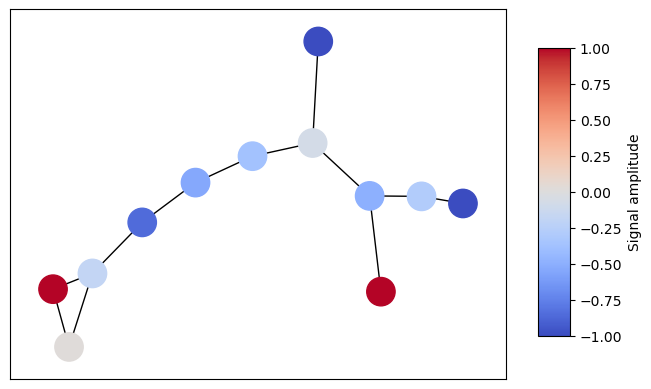

Mean and std:  (-0.23320922366695918, 0.6383498641783438)
Laplacian quadratic form:  6.915780110136277


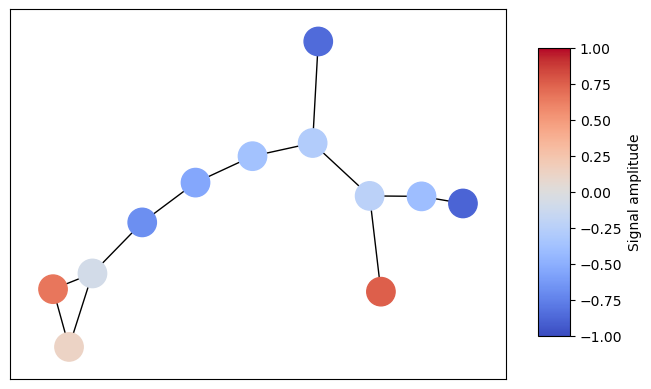

Mean and std:  (-0.2332092236669591, 0.5086256453665463)
Laplacian quadratic form:  2.877897908261094


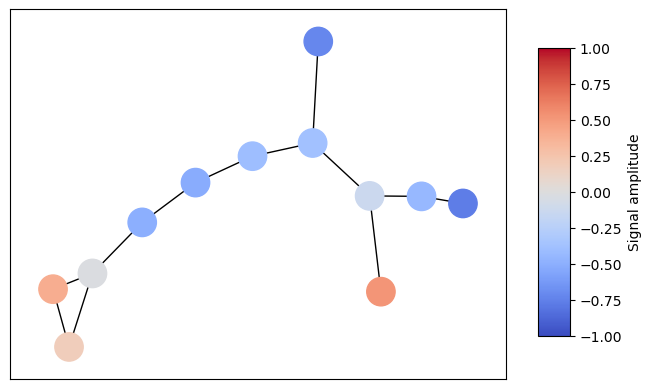

Mean and std:  (-0.23320922366695918, 0.40330003002758186)
Laplacian quadratic form:  1.3093108352160168


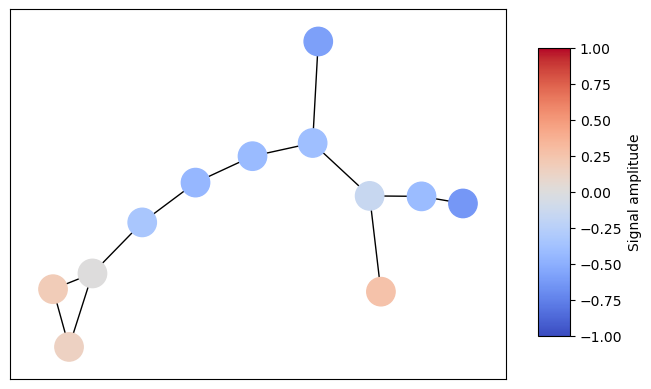

Mean and std:  (-0.23320922366695918, 0.2998116539089357)
Laplacian quadratic form:  0.5782834473167535


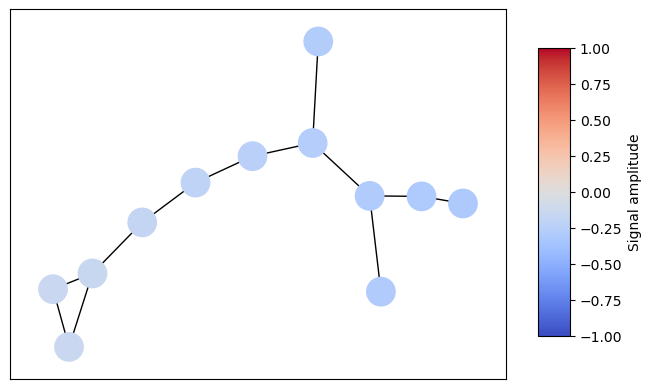

Mean and std:  (-0.23320922366695965, 0.061930671943603924)
Laplacian quadratic form:  0.004204284258566598


In [9]:
# Input parameters
num_nodes = 12
num_edges = 12
value_range = (-1, 1)
diffusion_timesteps = [0, 2, 5, 10, 100]

# Create the graph
G0 = create_graph(num_nodes, num_edges, value_range, edge_weight_range = [1,1])

# Perform diffusion and plot the graph at each timestep
for t in diffusion_timesteps:
    G = diffusion(G0,  diffusion_steps = t)
    plot_graph(G, labels=False, value_range=value_range)
    print("Mean and std: ", graph_stats(G))
    print("Laplacian quadratic form: ", signal_smoothness_on_graph(G))


In [232]:
#Sample the signal from the graph
samples = sample_signal_from_graph(G0, num_samples = 20, sampling_noise_std = 0.2)
print("Samples shape: ", samples.shape)
print("Samples: ", samples)

Samples shape:  (20, 12)
Samples:  [[ 0.13945938 -0.69840085  0.69861123 -0.73327626 -1.3473442  -0.45546843
   0.14136221 -0.83296117 -0.83386394  0.99591897 -0.8041123   0.84839112]
 [ 0.1899511  -0.79522755  1.17045683 -0.39078776 -0.95374416  0.06357978
   0.79386261 -0.93156441 -1.1257635   1.51736541 -1.33188778  0.60531788]
 [ 0.14950548 -0.97921491  1.3537604  -0.87245416 -0.39667819 -0.44157011
   0.25361894 -1.09206157 -1.03134275  0.66976727 -0.71614692  0.77804313]
 [ 0.30135289 -0.88011851  1.5126455  -0.99844253 -0.4596822  -0.86271313
   0.26760226 -0.98676368 -1.01257701  1.07156072 -0.79291707  0.31807208]
 [ 0.04841501 -1.05085123  0.61230706 -0.47053698 -1.01730262 -0.43522511
   0.44187934 -0.97339401 -0.6513557   0.96710526 -1.39823318  0.96963273]
 [ 0.06410066 -1.13861881  1.01395873 -0.63104439 -1.36403513 -0.23178302
   1.06918556 -0.89450733 -1.23499228  0.83795704 -1.01410773  0.5914141 ]
 [ 0.26175939 -0.72905558  0.99663906 -1.21596364 -1.07598928 -0.234800